# Working with Real Data
* Popular open data repositories:
  * [UC Irvine Machine Learning Repository] (http://archive.ics.uci.edu/ml/index.php)
  * [Kaggle datasets]  (https://www.kaggle.com/datasets)
  * [Amazon’s AWS datasets] (https://registry.opendata.aws/)
* Open Data Repositories
  * [http://dataportals.org/] (http://dataportals.org/)
  * [http://opendatamonitor.eu/] (http://opendatamonitor.eu/)
  * [http://quandl.com/] (http://quandl.com/)



First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Download Data

The first task you are asked to perform is to build a
model of housing prices in California using the California census data. This data has metrics such as the
population, median income, median housing price, and so on for each block group in California. 

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Take a Quick Look at the Data Structure

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY



# Data Information


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning
standards, but it’s perfect to get started. Notice that the total_bedrooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature. We will need to take care of this later.

#  Count Exisiting Categories

In [7]:
housing["ocean_proximity"].value_counts() #All attributes are numerical, except the ocean_proximity field

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Lets Check some statistics for the date

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored (so, for
example, count of total_bedrooms is 20,433, not 20,640). The std row shows the standard deviation
(which measures how dispersed the values are). The 25%, 50%, and 75% rows show the corresponding
percentiles: a percentile indicates the value below which a given percentage of observations in a group
of observations falls. For example, 25% of the districts have a housing_median_age lower than 18,
while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or
1st quartile), the median, and the 75th percentile (or 3rd quartile).

# plot a histogram for each numerical attribute.

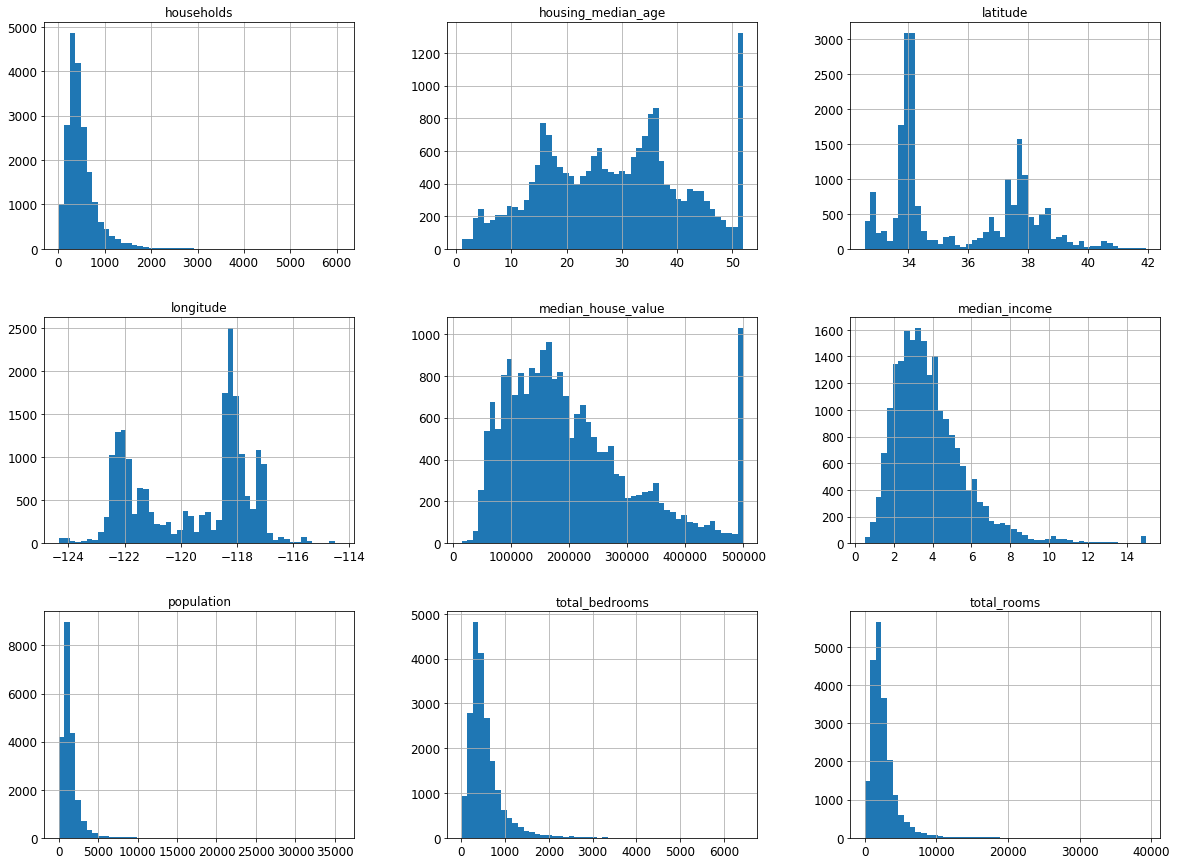

In [9]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Notice a few things in these histograms:
1. the median income attribute does not look like it is expressed in US dollars (USD). as it has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes.
2. These attributes have very different scales we need to exlore feature scaling
3. many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

# Create Test set 
Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [11]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


## check histogram of a feature

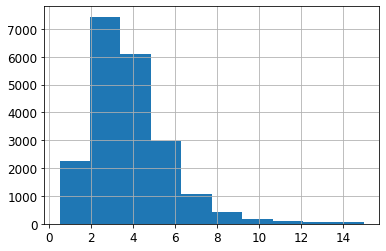

In [12]:
housing["median_income"].hist()

## Limit number of income categories

In [13]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

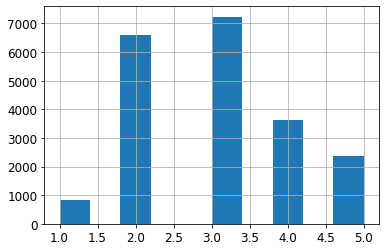

In [14]:
housing["income_cat"].hist()

#  Stratified Sampling:
This is generally fine if your dataset is large
enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a
significant sampling bias. When a survey company decides to call 1,000 people to ask them a few
questions, they don’t just pick 1,000 people randomly in a phone booth. They try to ensure that these 1,000
people are representative of the whole population. For example, the US population is composed of 51.3%
female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the
sample: 513 female and 487 male.

## Now you are ready to do stratified sampling based on the income category. For this you can use ScikitLearn’s StratifiedShuffleSplit class:

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

 ### Checking similarity with income attribute

In [16]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
# Now you should remove the income_cat attribute so the data is back to its original state:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Data Exploration

In [18]:
housing = strat_train_set.copy()

### Since there is geographical information (latitude and longitude),  it is a good idea to create a scatterplot of all districts to visualize the data

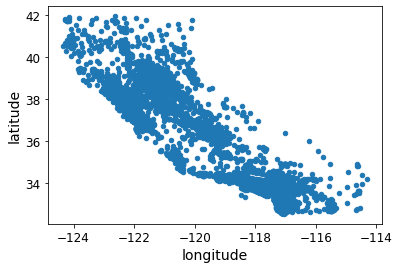

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude") 

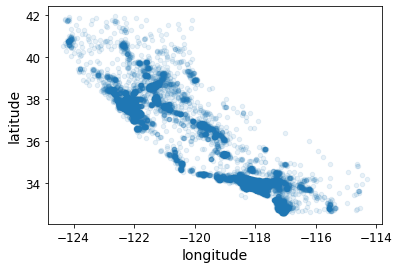

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) # to visualize places with high densoty

## The radius of each circle represents the district’spopulation (option s), and the color represents the price (option c). 
This image tells you that the housing prices are very much related to the location (e.g., close to the ocean)
and to the population density, as you probably knew already. It will probably be useful to use a clustering
algorithm to detect the main clusters, and add new features that measure the proximity to the cluster
centers.

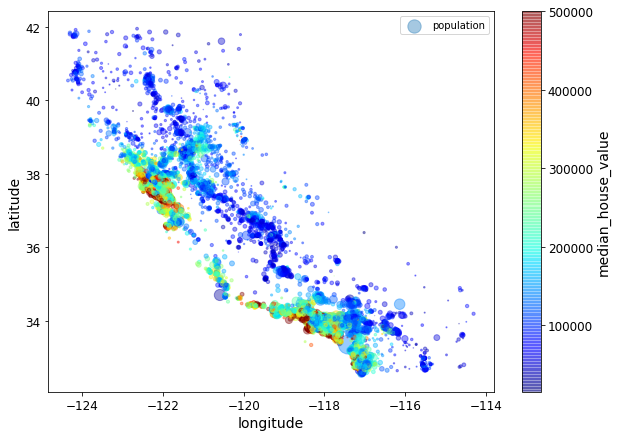

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()


Since the dataset is not too large, you can easily compute the standard correlation coefficient (also
called Pearson’s r) between every pair of attributes using the corr() method:

In [22]:
corr_matrix = housing.corr()
# let`s see now how much correlation between the attributes and median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong
positive correlation; for example, the median house value tends to go up when the median income goes up

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0179696250>,
      dtype=object)

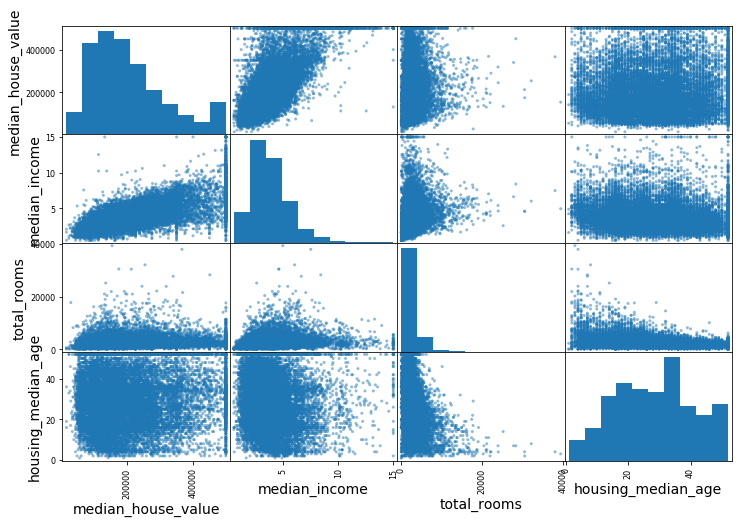

In [23]:
# correlation calculation using pandas` scatter matrix function
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The main diagonal (top left to bottom right) would be full of straight lines if Pandas plotted each variable
against itself, which would not be very useful. So instead Pandas displays a histogram of each attribute

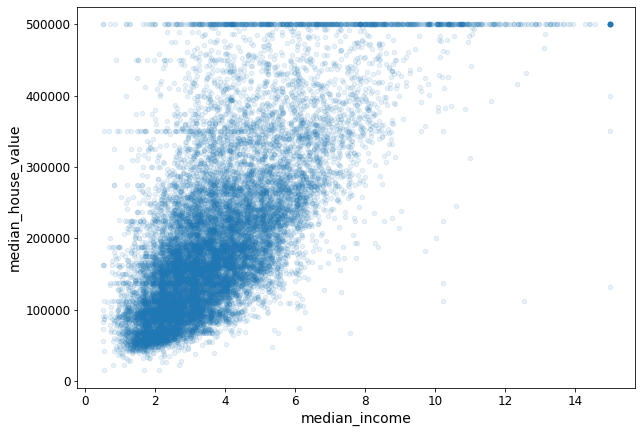

In [26]:
# The most promising attribute to predict the median house value is the median income, so let’s zoom in on
# their correlation scatterplot 
housing.plot(kind="scatter", x="median_income", y="median_house_value", figsize=(10,7),alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward
trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible
as a horizontal line at 500,000. But this plot reveals other less obvious straight lines: a horizontal line
around 450,000, another around 350,000, perhaps one around 280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms from learning to
reproduce these data quirks

## Attribute combinations

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms


In [28]:
# lets copy the data first 
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning
Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to
take care of them. You noticed earlier that the total_bedrooms attribute has some missing values.

In [30]:
# find nan values
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [32]:
# housing.dropna(subset=["total_bedrooms"]) # option 1: will drop the whole row containing nan value
# housing.drop("total_bedrooms", axis=1) # option 2: drop the whole column
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median) # option 3: fill the nan values places wit median 

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
          ...  
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Length: 16512, dtype: float64

Don’t forget to save the median value that you have computed.
You will need it later to replace missing values in the test set when you want to evaluate your system, and
also once the system goes live to replace missing values in new data.

#### Sklearn imputer class for misssing data handling

In [34]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [36]:
# Remove the text attribute because median can only be calculated on numerical attributes:
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [39]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

### Handling Text and Categorical Attributes

In [40]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [41]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20
    
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Custom Transformers


In [45]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [46]:
# get attribute index
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]


In [47]:
rooms_ix

3

In [52]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False)
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [53]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### pipeline and feature scaling
There are two common ways to get all attributes to have the same scale: min-max scaling and
standardization.
* Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled
so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max
minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a
feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason.
* Standardization is quite different: first it subtracts the mean value (so standardized values always have a
zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Unlike
min-max scaling, standardization does not bound values to a specific range, which may be a problem for
some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1).

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [56]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.61493744,
        -0.31205452, -0.08649871],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  1.33645936,
         0.21768338, -0.03353391],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.5320456 ,
        -0.46531516, -0.09240499],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ..., -0.3167053 ,
         0.3469342 , -0.03055414],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.09812139,
         0.02499488,  0.06150916],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.15779865,
        -0.22852947, -0.09586294]])

In [58]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [59]:
housing_prepared.shape

(16512, 15)

### Select and Train a Model

In [61]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [211888.26540421 321274.25149998 210853.46010112  62261.10820843
 194921.76527689]


In [63]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [65]:
# chec mean square error between predictions and labels
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68911.76054233838